In [63]:
import time
import numpy as np
import pandas as pd
import json
import seaborn as sb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sb
import pickle
import re

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

In [88]:
def qual_encode(qual):
    
    qual_list = ['Masters','MBA','PhD','J.D.']
    qual_encodings = {'Masters': 1, 'MBA': 1, 'PhD': 2, 'J.D.': 3}
    if qual in qual_list:
        return qual_encodings[qual]
    else:
        return 0
    
def get_exp(bio):
    
    if 'years' in bio:
        yrs = np.array([int(i) for i in re.findall('\d+', bio)])
        if len(yrs[yrs<50])>0:
            return max(yrs[yrs<50])
        else:
            return 0
    else:
        return 0 

In [3]:
dbname = 'tutor_db'
username = 'codonnell'
pswd = '7883511'

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM tutor_main
"""
tutor_data = pd.read_sql_query(sql_query,con)
tutor_data = tutor_data.drop_duplicates(subset='tut_id')
tutor_data['log_hourly_rate'] = np.log(tutor_data['hourly_rate'])
tutor_data['qual_encoded'] = tutor_data.apply(lambda x: qual_encode(x['qual_1']) + qual_encode(x['qual_2']), axis =1) 
tutor_data.head()

,index,description,hourly_rate,bio,background_check,tut_id,photo,rating_count,rating_av,review_count,...,sunday_hours,monday_hours,tuesday_hours,wednesday_hours,thursday_hours,friday_hours,saturday_hours,mean_hours,log_hourly_rate,qual_encoded
0,0,Fun Experienced Tutor!,60,"['Hi!', ""I'm an experienced tutor with a sense...",1,7269032,1,269,4.98885,15.0,...,0.583333,0.416667,0.583333,0.375000,0.375000,0.583333,0.583333,0.500000,4.094345,1
1,1,"Math, Writing and Econ Specialist, 8+ Years Tu...",75,"['From Algebra to MLA, Middle School to MBA, I...",1,7277990,1,338,4.93195,18.0,...,0.500000,0.541667,0.583333,0.583333,0.583333,0.500000,0.333333,0.517857,4.317488,1
2,2,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95,"[""I am an experienced (3000+ hours) tutor cert...",1,7611743,1,1046,4.94349,74.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.553877,0
3,3,Congratulations to my students entering Harvar...,95,['MARCH 2020: IN ORDER TO ASSIST MORE STUDENTS...,1,7614535,1,1602,4.97940,32.0,...,0.000000,0.375000,0.541667,0.541667,0.250000,0.416667,0.375000,0.357143,4.553877,1
4,13,"Patient, Knowledgeable and Effective Spanish T...",125,['I am a high school AP Spanish Language teach...,1,8022035,1,67,4.98507,12.0,...,0.041667,0.166667,0.083333,0.125000,0.125000,0.083333,0.000000,0.089286,4.828314,0


In [4]:
ivys = 'Brown|Columbia|Dartmouth|Harvard|Cornell|Pennsylvania|Princeton|Yale'

In [17]:
tutor_data['ivy_1e'] = tutor_data['inst_1'].str.contains(ivys).astype(int)
tutor_data['ivy_2e'] = tutor_data['inst_2'].str.contains(ivys).astype(int)
tutor_data['ivy_3e'] = tutor_data['inst_3'].str.contains(ivys).astype(int)
tutor_data['ivy_tot'] = tutor_data['ivy_1e']+tutor_data['ivy_2e']+tutor_data['ivy_3e']
#tutor_data['inst_1e'] = tutor_data['inst_1'].apply(ivy)
#tutor_data['inst_1e'] = tutor_data['inst_1'].apply(ivy)

In [89]:
tutor_data['state_1e'] = tutor_data['inst_1'].str.contains('State').astype(int)
tutor_data['state_2e'] = tutor_data['inst_2'].str.contains('State').astype(int)
tutor_data['state_3e'] = tutor_data['inst_3'].str.contains('State').astype(int)
tutor_data['state_tot'] = tutor_data['state_1e']+tutor_data['state_2e']+tutor_data['state_3e']
tutor_data['experience'] = tutor_data['bio'].apply(get_exp)

In [6]:
sql_query = """
SELECT * FROM tutor_subjects
"""
tutor_subjects = pd.read_sql_query(sql_query,con)
tutor_subjects.head()

,index,tutor_ids,subjects
0,0,7269032,Precalculus
1,1,7269032,French
2,2,7269032,European History
3,3,7269032,Calculus
4,4,7269032,Spanish


In [7]:
tutors_joined = tutor_subjects.groupby('tutor_ids')['subjects'].apply(lambda x: ' '.join(x)).reset_index()
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(float)
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(int)

In [145]:
all_features = ['qual_encoded', 'rating_count','rating_av','review_count','bio_length',
               'num_subjects','hours_tutoring','edu_length','mean_hours',
                'ivy_1e','ivy_2e','ivy_3e','hourly_rate','state_1e','state_2e',
                'state_3e','experience',0,1,'log_hourly_rate']
#all_features = ['qual_encoded','bio_length','num_subjects','edu_length','mean_hours','log_hourly_rate']

In [99]:
tfidf = pickle.load(open('tfidf.sav', 'rb'))
#tfidf.fit(tutors_joined['subjects'])
#text = tfidf.transform(tutors_joined['subjects'])

subjects_df = pd.DataFrame(PCA(n_components=2).fit_transform(text.todense()))

In [146]:
tdf = tutors_joined.join(subjects_df).drop_duplicates(subset='tutor_ids')
tutors_tfidf = pd.merge(tutor_data,tdf,left_on = 'tut_id',right_on = 'tutor_ids')[all_features]

In [151]:
tutors_outliers = tutors_tfidf[(tutors_tfidf['log_hourly_rate']<4.7) 
                               & (tutors_tfidf['log_hourly_rate']>2.9)]
                             # & (tutors_tfidf['state'])]
                    
tutors_outliers = tutors_outliers.drop('hourly_rate',axis=1)

In [148]:
tutors_outliers = tutors_tfidf[(tutors_tfidf['hourly_rate']<200) 
                               & (tutors_tfidf['hourly_rate']>20)]
                             # & (tutors_tfidf['state'])]
                    
tutors_outliers = tutors_outliers.drop('log_hourly_rate',axis=1)

In [152]:
tutors_outliers.head()

,qual_encoded,rating_count,rating_av,review_count,bio_length,num_subjects,hours_tutoring,edu_length,mean_hours,ivy_1e,ivy_2e,ivy_3e,state_1e,state_2e,state_3e,experience,0,1,log_hourly_rate
0,1,269,4.98885,15.0,376,5,839.0,7,0.500000,0,0,0,0,0,0,15,-0.060557,0.207115,4.094345
1,1,338,4.93195,18.0,323,31,962.0,7,0.517857,0,0,0,0,0,0,9,-0.064848,-0.071893,4.317488
2,0,1046,4.94349,74.0,248,72,3899.0,4,1.000000,0,0,0,0,0,0,30,-0.022238,-0.159213,4.553877
3,1,1602,4.97940,32.0,417,19,5592.0,7,0.357143,1,0,0,0,0,0,0,-0.214705,-0.152133,4.553877
5,0,51,4.62745,9.0,321,40,91.0,10,0.000000,0,0,0,0,0,0,0,0.068457,-0.033185,3.688879


In [171]:
poly = PolynomialFeatures(2)

# Set up feature data and target data
X = tutors_outliers.drop('log_hourly_rate', axis=1)

#X = poly.fit_transform(X)
y = tutors_outliers['log_hourly_rate']

# Initialise a balanced logisitic regression model
#model_base = XGBRegressor(n_estimators=400, learning_rate=0.01, random_state=1)
model_base = LinearRegression()

# Perform feature normalisation
scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(scaler.fit_transform(X), y, train_size=0.8, test_size=0.2, random_state = 1)

#model_base.fit(train_X.values, train_y.values)
model_base.fit(train_X, train_y.values)

preds_val = model_base.predict(val_X)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

11.955716730190526


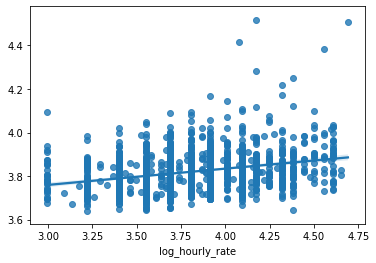

In [154]:
sb.regplot(val_y,preds_val)

In [168]:
# Set up feature data and target data
X = tutors_outliers.drop('log_hourly_rate', axis=1)

#X = poly.fit_transform(X)
y = tutors_outliers['log_hourly_rate']

model_base = Lasso(alpha=0.003)
#model_base = XGBRegressor(n_estimators=500, learning_rate=0.01, random_state=1)

# Perform feature normalisation
scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(scaler.fit_transform(X), y, train_size=0.8, test_size=0.2, random_state = 1)

#model_base.fit(train_X.values, train_y.values)
model_base.fit(train_X, train_y.values)

preds_val = model_base.predict(val_X)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

11.919243918471173


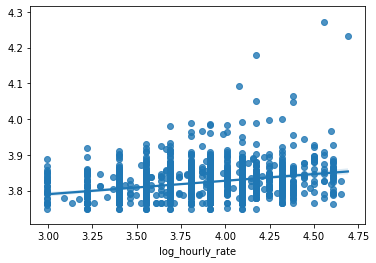

In [160]:
sb.regplot(val_y,preds_val)

In [157]:
np.exp(3.9)-np.exp(3.8)

4.701264612229352

In [147]:
test_data = tutor_data[(tutor_data['hourly_rate']<100) 
                               & (tutor_data['hourly_rate']>20)]

In [171]:
#edges = [20,30,40,50,60,70,80,90,100]
edges = [20,40,60,80,100]
bio_bins = []

for i in range(0,len(edges)-1):
    df = test_data[(test_data['hourly_rate']>=edges[i])& (test_data['hourly_rate']<edges[i+1])]
    bios = ' '.join(df['bio'])
    bio_bins.append(bios)

In [172]:
bio_df = pd.DataFrame({'interval':np.array(edges[1:]), 'bios': np.array(bio_bins)})

In [174]:
stopWords = esw 

tfidf = TfidfVectorizer(
    min_df = 0,
    max_df = 0.95,
    max_features = 20000,
    stop_words = stopWords,
    ngram_range = (1,2)
)
tfidf.fit(bio_df['bios'])
text = tfidf.transform(bio_df['bios'])

In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)

In [175]:
labels = tfidf.get_feature_names()

for i in range(0,len(edges)-1):
    
    print(','.join([labels[t] for t in np.argsort(np.array(text.todense()[i,:]))[0][-10:]]))

denver,little bit,military,english speakers,school love,korean,colombia,small groups,early childhood,substitute teacher
returned,facilitate,obtaining,university north,indiana,gis,small groups,english speakers,substitute teacher,early childhood
geometry pre,teaching esl,painting,mathematics education,relations,accent,provides,denver,doctoral,small groups
massachusetts institute,cooper,ian,stacy,wharton,martial arts,congratulations,stony,stony brook,brook


In [169]:
[labels[t] for t in np.argsort(np.array(text.todense()[0,:]))[0][-10:]]

['open',
 'substitute',
 'younger',
 'illustrator',
 'charlotte',
 'activities',
 'later',
 'lab',
 'teaching english',
 'special education']

In [61]:
bio1 =tutor_data[tutor_data['bio'].str.contains('years')]['bio'].iloc[0]
bio2 =tutor_data[~tutor_data['bio'].str.contains('years')]['bio'].iloc[3]

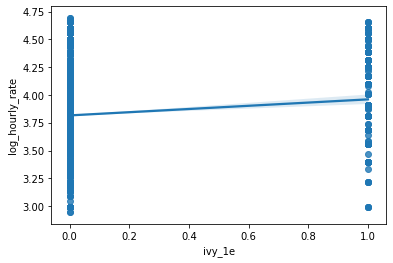

In [116]:
sb.regplot(tutors_outliers['ivy_1e'],tutors_outliers['log_hourly_rate'])

In [192]:
tutor_ca = pd.merge(tutor_data,tdf,left_on = 'tut_id',right_on = 'tutor_ids')
tutor_ca = tutor_ca[tutor_ca['state']=='CA'][all_features]
tutor_ca = tutor_ca.drop('hourly_rate',axis=1)
tutor_ca = tutor_ca[(tutor_ca['log_hourly_rate']<4.7) 
                               & (tutor_ca['log_hourly_rate']>2.9)]

In [195]:
X = tutor_ca.drop('log_hourly_rate', axis=1)

#X = poly.fit_transform(X)
y = tutor_ca['log_hourly_rate']

model_base = Lasso(alpha=0.003)
#model_base = XGBRegressor(n_estimators=500, learning_rate=0.01, random_state=1)

# Perform feature normalisation
scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(scaler.fit_transform(X), y, train_size=0.8, test_size=0.2, random_state = 1)

#model_base.fit(train_X.values, train_y.values)
model_base.fit(train_X, train_y.values)

preds_val = model_base.predict(val_X)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

13.413571189628287


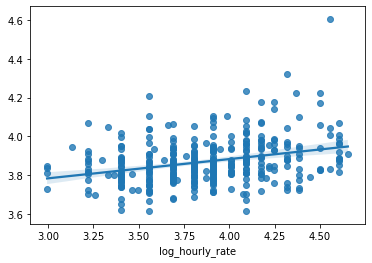

In [196]:
sb.regplot(val_y,preds_val)

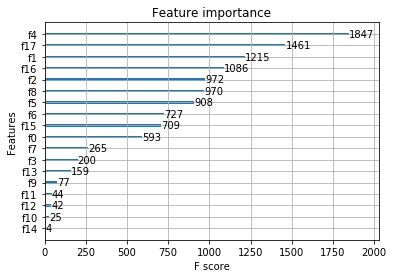

In [188]:
plot_importance(model_base)
plt.show()

In [198]:
tutor_data.groupby('state')['hourly_rate'].mean()

state
AL     70.000000
AZ     45.859813
CA     55.920901
CO     48.272727
CT    180.000000
DC     58.707692
DE     48.781250
FL     45.384546
GA     45.550725
IL     52.996473
IN     44.238095
KS     49.166667
KY     79.000000
MA    173.500000
MD     53.842857
MI     44.507246
MN     49.167832
MO     45.701031
NC     44.375887
NE     75.000000
NJ     57.391608
NM     39.179487
NV     41.857143
NY     72.618307
OH     46.823529
OK     15.000000
OR     42.500000
PA     48.549828
SC     75.230769
TN     47.306452
TX     47.542657
UT     42.718750
VA     47.888889
WA     52.807175
WI     12.000000
WV     35.000000
Name: hourly_rate, dtype: float64